# Text Analytics Group Assignment2
Due: September 25, 2017, by 11:59 p.m. In this assignment you are an analytics consultant to a   (i) brand manager, (ii) product manager and (iii)advertising manager. Your job is    to give advice/insights to these individuals based on the analysis of social media conversations. The detailed tasks are described below. We use cars as an example of a “high involvement” good (recall from class discussions that for high involvement goods, people use social media heavily for awareness building and research).

1.Develop a   crawler/scraper to fetch messages posted in Edmunds.com discussion forums. The crawler output should be a .csv file with the following columns: date, userid, and message (even though you will only use the messages in your analysis). Before you develop the crawler, carefully study one of the forums on Edmunds.com to understand the html as well as the threading structures.

2.Fetch between 5,000 and 10,000 posts about cars from a General topics forum. Do NOT choosea forum dedicated to a   particular brand or model. Instead, you can choose the General & Sedans categories and then select, for example, the Entry Level Luxury forum https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedansThe idea is    to have multiple brands and models being discussed without one of them being the focal point.

3.Once you fetch the data, find the top 10 brands from frequency counts. You will need to write a script to count the frequencies. Be sure not to count a mention more than once per post, evenif   it    is mentioned multiple times.Replace modelswith brands so that from now on you have to deal with only brands and not models. You will need another script for this job. This step is meant to help simplify the analysis. A    list of model and brand names (not exhaustive) are provided in a separate file.

#### Task A:
Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a   script to do this task). Show the brands on a   multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available onthe Internet). 

In [1]:
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords, wordnet
import itertools
import matplotlib.pyplot as plt
from sklearn import manifold
from nltk import pos_tag, word_tokenize
from nltk.probability import FreqDist

In [2]:
#car forum data

forum_data =pd.read_csv('/Users/brettscroggins/Downloads/reed_new_out.csv', header = 0)
forum_data = forum_data[['date','userid','message']]

df2=pd.DataFrame([['April 12, 2002 2:53PM','dani','bmw toyota pontiac honda acura audi nissan infiniti ford subaru']], columns=['date','userid','message'])
forum_data=forum_data.append(df2)
forum_data['message']=forum_data['message'].str.lower()
len(forum_data['message'].value_counts())

5750

In [3]:
#list of car brands/names
model_list =pd.read_csv('Cars make model list3.csv', header = 2)
model_list['Search']=model_list['Search'].str.lower()

In [4]:
# some of the Search values from the model_list df have a weird format after that we need to remove
# 'legend\xca'.replace('\xc2\xa0','')
model_list['Search'].replace('\xca','').values

ls=model_list['Search'].tolist()
for i in range(len(ls)):
    ls[i]=ls[i].replace('\xca','')
range(len(ls))
model_list['Search1']=ls #setting new column equal to correct values
model_list[model_list['Replace']=='audi']

,Replace,Search,Search1
9,audi,quattro,quattro
10,audi,a4,a4
11,audi,a6,a6
12,audi,a5,a5
13,audi,a7,a7
14,audi,q3,q3
15,audi,q5,q5
16,audi,q7,q7
17,audi,a8,a8
18,audi,a3,a3


In [5]:
def replace_model(s):
    for model in model_list['Search1'].values:
        if model in s:
            s=s.replace(model,model_list[model_list['Search1']==model]['Replace'].values[0])
    return s

In [6]:
#mapping that function to forum df
forum_data['message_clean']=forum_data['message'].astype(str).map(replace_model)
forum_data[:5]

,date,userid,message,message_clean
0,"March 23, 2002 7:04PM",cybersol,entry level performance luxury sedans are a ho...,entry level performance luxury sedans are a ho...
1,"March 25, 2002 5:54AM",merc1,i personally think that with a few tweaks the ...,i personally think that with a few tweaks the ...
2,"March 25, 2002 7:06AM",fredvh,i am debating a new purchase and these two are...,i am debating a new purchase and these two are...
3,"March 25, 2002 5:02PM",blueguydotcom,"great handling, rwd, excellent engine and the ...","great handling, rwd, hyundailent engine and th..."
4,"March 25, 2002 11:04PM",hungrywhale,and no manual tranny. that may not matter to ...,and no manual tranny. that may not matter to ...


In [7]:
#removing stopwords and adding to new column in df
stop = stopwords.words('english')
forum_data['message_without_stopwords'] = forum_data['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
forum_data[:5]

,date,userid,message,message_clean,message_without_stopwords
0,"March 23, 2002 7:04PM",cybersol,entry level performance luxury sedans are a ho...,entry level performance luxury sedans are a ho...,entry level performance luxury sedans hot area...
1,"March 25, 2002 5:54AM",merc1,i personally think that with a few tweaks the ...,i personally think that with a few tweaks the ...,personally think tweaks c320 could also sit to...
2,"March 25, 2002 7:06AM",fredvh,i am debating a new purchase and these two are...,i am debating a new purchase and these two are...,debating new purchase two top ltoyota. price d...
3,"March 25, 2002 5:02PM",blueguydotcom,"great handling, rwd, excellent engine and the ...","great handling, rwd, hyundailent engine and th...","great handling, rwd, hyundailent engine best w..."
4,"March 25, 2002 11:04PM",hungrywhale,and no manual tranny. that may not matter to ...,and no manual tranny. that may not matter to ...,"manual tranny. may matter you, certainly matte..."


In [8]:
#count the number of messages that contain each brand name
#careful- don't want to count same message twice if brand is stated twice

counter={}
for brand in model_list['Replace'].drop_duplicates():
    if len(forum_data['message_without_stopwords'].str.contains(brand).value_counts().values)>1:
        count=forum_data['message_without_stopwords'].str.contains(brand).value_counts()[True]
    else:
        count=0
    counter[brand]=count

In [9]:
counterlist=[]
for key, value in counter.iteritems():
    temp = [key,value]
    counterlist.append(temp)
counterlist

sorted(counterlist, key=lambda x: x[1],reverse=True)
allbrands=sorted(counterlist, key=lambda x: x[1],reverse=True)
top10=allbrands[:10]
top10df = pd.DataFrame(top10)
top10df.columns = ['Car Type', 'Count']
top10df

,Car Type,Count
0,bmw,1866
1,toyota,1654
2,pontiac,1088
3,honda,683
4,acura,675
5,audi,594
6,nissan,562
7,infiniti,506
8,ford,296
9,subaru,277


In [10]:
#dictionary of top 10 to values and list of top 10 brands
num={}
for i in top10:
    num[i[0]]=i[1]

listof10=[]
for i in top10:
    listof10.append(i[0])
print listof10

['bmw', 'toyota', 'pontiac', 'honda', 'acura', 'audi', 'nissan', 'infiniti', 'ford', 'subaru']


In [11]:
def lift(a, b):
    num = len(forum_data)
    num_a = len(forum_data[forum_data['message_without_stopwords'].str.contains(a)])
    num_b = len(forum_data[forum_data['message_without_stopwords'].str.contains(b)])
    if_has_a = forum_data[forum_data['message_without_stopwords'].str.contains(a)]
    num_a_and_b = len(if_has_a['message_without_stopwords'][if_has_a['message_without_stopwords'].str.contains(b)])
    return num*float(num_a_and_b)/(num_a * num_b)

In [12]:
lift_df = pd.DataFrame(columns=listof10, index=listof10)

for brand1, series in list(lift_df.iterrows()):
    for brand2 in series.index:
        if brand1 != brand2:
            lift_df[brand2].loc[brand1] = lift(brand1, brand2)

lift_df

,bmw,toyota,pontiac,honda,acura,audi,nissan,infiniti,ford,subaru
bmw,NaN,1.28502,1.41893,1.26379,1.42085,1.64585,1.18907,1.8954,1.43192,1.1839
toyota,1.28502,NaN,1.27679,1.70173,1.39096,1.39848,1.50916,1.32439,1.50933,1.28525
pontiac,1.41893,1.27679,NaN,1.4683,1.65078,1.5275,1.70889,2.79984,1.05763,1.37919
honda,1.26379,1.70173,1.4683,NaN,2.41676,1.35182,2.42142,1.45328,2.05599,1.37314
acura,1.42085,1.39096,1.65078,2.41676,NaN,2.13095,1.87183,3.00862,1.64695,1.88342
audi,1.64585,1.39848,1.5275,1.35182,2.13095,NaN,1.48723,2.53535,1.80587,1.78939
nissan,1.18907,1.50916,1.70889,2.42142,1.87183,1.48723,NaN,2.19249,1.9781,1.52044
infiniti,1.8954,1.32439,2.79984,1.45328,3.00862,2.53535,2.19249,NaN,1.54177,1.81227
ford,1.43192,1.50933,1.05763,2.05599,1.64695,1.80587,1.9781,1.54177,NaN,1.83064
subaru,1.1839,1.28525,1.37919,1.37314,1.88342,1.78939,1.52044,1.81227,1.83064,NaN


In [13]:
inv_lift_df=1/lift_df
inv_lift_df=inv_lift_df.fillna(0)

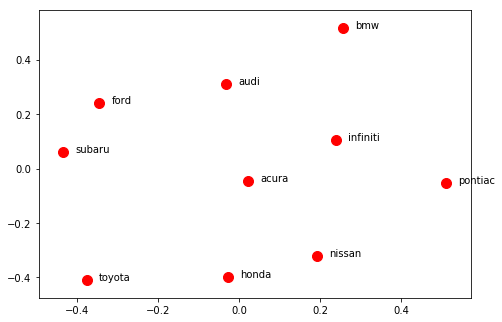

In [14]:
mds=manifold.MDS(n_components=2, random_state=1, dissimilarity='precomputed')
fit=mds.fit(inv_lift_df).embedding_
x_coef=fit[:,0]
y_coef=fit[:,1]
lst=list(inv_lift_df.index)

fit=plt.figure(1)
ax=plt.axes([0.,0.,1.,1.])

plt.scatter(x_coef, y_coef, color='red',s=100, lw=1, label=lst)

for i, lst in enumerate(lst):
    ax.annotate(lst, (x_coef[i]+0.03,y_coef[i]))

plt.show()

#### Task B:
What insights can you offer brand managers from your analysis in Task A    (choose two brands that you can offer the most interesting/useful insights for)? 


**Insights from brand lift values and MDS plot:**

Infiniti has positioned itself well as a brand that is used as a metric across many other brands. Though it was mentioned at less than one-third of the frequency as BMW, it has significantly higher lift values with a variety of brands. This strongly indicates that people commonly accept this brand as the metric by which they measure other brands. Though BMW and Toyota have exceptionally high raw mentions, when it comes to attracting new customers to switch from other brands, this data indicates they are not in a favorable position to attract customers in such a way.

While Honda has lift values across a handful of brands, and more raw mentions than Infiniti, the comparisons are with less total brands. More importantly, the brands with which Honda is compared are less varied and are exclusively with brands considered to be the lower-tier brands of the luxury pool of brands. Though they are finding themselves mentioned regularly as a metric, they are clearly used as the low-tier metric, which Honda executives may want to attempt to alter.

#### Task C:
What are 5   most frequently mentioned attributes of cars in the discussions? Note that the same attribute may be described by different words –   e.g., pick-up and acceleration may both referto a more general attribute, “performance”. You have to make suitable replacements. Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5   brands? You DON’T have to do a sentiment analysis for this assignment.
While BMW has claimed that they are the “ultimate driving machine”, is    that how people feel on Edmunds? Show your analysis.   

In [15]:
top5brands = top10[:5]
top5brands

message_list=forum_data['message_without_stopwords'].values.tolist()
message_list
message_list[0] #the first job description (complete)
wordsinlist=[]
for i in range(0,len(message_list)):
    words1=word_tokenize(message_list[i])
    wordsinlist.append(words1)

In [16]:
words = [item for sublist in wordsinlist for item in sublist]

In [17]:
print words[:10]
frq=FreqDist(words)
#frq
frq.most_common(50)
count=0
for w in words:
    if w =='build':
        count+=1
count

['entry', 'level', 'performance', 'luxury', 'sedans', 'hot', 'area', 'car', 'manufacturers', 'enthusiasts']


86

In [18]:
attribute_dict = {'w8':'acceleration','weight':'acceleration','pick-up':'acceleration','rpm':'acceleration','speed':'acceleration','mph':'acceleration',
                  'cost':'price','affordable':'price','expensive':'price','cheap':'price','value':'price','fuel':'price','efficiency':'price','mpg':'price','hybrid':'price',
                  'suspension':'handling','turning':'handling','cornering':'handling','steering':'handling','awd':'handling','rwd':'handling',
                  'torque':'power','hp':'power','horsepower':'power','engine':'power','automatic':'power','manual':'power','transmission':'power',
                  'luxury':'interior','features':'interior','stereo':'interior','gps':'interior','cd':'interior','heated':'interior','boot':'interior','clubs':'interior','nav':'interior','leather':'interior',
                  'spoiler':'exterior','carbon':'exterior','lift':'exterior','paint':'exterior','color':'exterior','finish':'exterior','aluminum':'exterior',
                  'reliability':'quality','build':'quality','safety':'quality','crash':'quality'}

In [19]:
#replaces words that fall into attribute category with that attribute
def replace_attribute(s):
    attr=[]
    for word in s:
        if word in attribute_dict:
            attr.append(attribute_dict[word])
        else:
            attr.append(word)    
    return attr

counter = 0
new_words = replace_attribute(words)
#print new_words
for w in new_words:
    if w =='acceleration':
        counter+=1
counter

1115

In [20]:
attribute_list = ['acceleration', 'handling','power', 'price','interior','exterior','quality']
##need help on brainstorming other attributes, i don't know cars
handlecount = 0
powcount=0
pricecount=0
accelcount=0
makecount = 0 
intcount=0
extcount=0
qualitycount=0
for w in new_words:
    if w =='acceleration':
        accelcount+=1
    if w=='handling':
        handlecount+=1
    if w=='power':
        powcount+=1
    if w=='price':
        pricecount+=1
    if w=='interior':
        intcount+=1
    if w=='exterior':
        extcount+=1
    if w=='quality':
        qualitycount+=1
attr_freq_list = [['acceleration',accelcount],['handling',handlecount],['price',pricecount],['power',powcount],['interior',intcount],['exterior',extcount],['quality',qualitycount]]
attr_freq_list.sort(key=lambda x: x[1], reverse=True)

attr_freq_list[:5]

[['power', 3401],
 ['handling', 2389],
 ['interior', 2087],
 ['price', 1915],
 ['acceleration', 1115]]

In [21]:
temp_list = ['power','handling','interior','price','acceleration']

listof5 = listof10[:5]

attribute_df = pd.DataFrame(columns=listof5, index=temp_list)

for attribute, series in list(attribute_df.iterrows()):
    for brand in series.index:
        attribute_df[brand].loc[attribute] = lift(brand, attribute)

attribute_df

,bmw,toyota,pontiac,honda,acura
power,1.49637,1.53075,1.59265,1.8009,1.75574
handling,1.55007,1.52657,1.67789,1.45791,1.61568
interior,1.35052,1.36037,1.92626,1.31775,1.65718
price,1.54689,1.44077,1.71213,1.5234,1.49173
acceleration,1.46756,1.83466,1.76869,1.78801,1.53508


#### Task D:
What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it   is    positive). 

#### Task E:
Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand? Provide the following details in your write-up (I    am not setting a   strict page limit, but 3-4 pages, single-spaced, 11 font size should be enough with screenshots)

1.Which forum you chose (provide URL) 

2.Which 10 brands you chose –   provide the frequency table

3.Show all lift calculations in a   table.

4.Show the MDS map (put screenshots in your report)

5.State the 5   attributes you chose (again, a   table is    good here). 

6.For task E, provide all details of your analysis –   e.g., how you measured “aspirational” and howyou found the most aspirational brand.

7.Advice/insights based on your analysis for brand, product and advertising managers. Your submission should include all scripts as well as your answers to the questions above (generally speaking, I  won’t run these scripts, but if   the numbers don’t look right, I may run some of them). Also include the final data file after all replacements of models and attributes have been done.

In [22]:
att_df=pd.DataFrame(columns=['Replace','Search'])
att_df['Replace']=attribute_dict.values()
att_df['Search']=attribute_dict.keys()

In [23]:
def replace_att(s):
    for word in att_df['Search'].values:
        if word in s:
            s=s.replace(word,att_df[att_df['Search']==word]['Replace'].values[0])
    return s

In [24]:
# map function to forum_df to turn words into attributes
forum_data['message_clean']=forum_data['message'].astype(str).map(replace_att)

In [25]:
# mapping that function to forum df to turn models into brands
forum_data['message_clean']=forum_data['message_clean'].astype(str).map(replace_model)

In [26]:
# removing stopwords and adding to new column in df
stop = stopwords.words('english')
forum_data['message_without_stopwords'] = forum_data['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [27]:
# # Run only to export as CSV
# export as csv
# forum_data_export=forum_data[['date','userid','message_without_stopwords']]
# forum_data_export.to_csv('final_output.csv',sep=',')